# Generate a NSFW circles using evolutionary algorithm
The generated image is actually pretty safe for work, but with a high open NSFW score.

The code is derived from https://scturtle.me/posts/2014-04-18-ga.html 
It depends on DEAP. 

In [1]:
from open_nsfw import nsfw_score

Using gpu device 0: GeForce GTX 965M (CNMeM is disabled, cuDNN 4007)


In [2]:
from deap import base, creator, tools, algorithms
from PIL import Image, ImageDraw
from random import randint

In [3]:
SIZE_X, SIZE_Y = 256, 256
NUMBER_OF_CIRCLES = 50
POPULATION = 50
NGEN = 200
POLY = 4
R = min(SIZE_X, SIZE_Y)//4

In [4]:
def gen_one_circle():
    return (randint(0, SIZE_X), randint(0, SIZE_Y), randint(1, R//4),
            randint(0,255), randint(0,255), randint(0,255), randint(128,255))

In [5]:
creator.create("Fitness", base.Fitness, weights=(1.0,))  # maximize fitness
creator.create("Individual", list, fitness=creator.Fitness)  # individual class

toolbox = base.Toolbox()
toolbox.register("attr", gen_one_circle)  # the above function
toolbox.register("individual", tools.initRepeat,  # initialization of individual
                 creator.Individual, toolbox.attr, NUMBER_OF_CIRCLES)
toolbox.register("population", tools.initRepeat,  # initialization of population
                 list, toolbox.individual)

In [6]:
def circles_to_image(circle):
    im = Image.new('RGB', (SIZE_X, SIZE_Y), (0, 0, 0))
    for c in circle:
        mask = Image.new('RGBA', (SIZE_X, SIZE_Y))
        draw = ImageDraw.Draw(mask)
        draw.ellipse((c[0]-c[2], c[1]-c[2], c[0]+c[2], c[1]+c[2]), fill = c[3:], outline =c[3:])
        im.paste(mask, mask=mask)
        del mask, draw
    return im

def evaluate(t2):
    return nsfw_score(circles_to_image(t2)),

In [7]:
range_table=[(0, SIZE_X-1), (0, SIZE_Y-1), (1, R)]+[(0,255)]*3+[(128, 255)]
def mutate(circles):
    e0 = circles.fitness.values
    for i in range(10):
        tid = randint(0, NUMBER_OF_CIRCLES - 1)
        oldt = circles[tid]
        p = randint(-1, 3 + 4 - 1)
        if p == -1:
            tid2 = randint(0, NUMBER_OF_CIRCLES - 1)
            circles[tid], circles[tid2] = circles[tid2], oldt
        else:
            t = list(oldt)
            t[p] = randint(*range_table[p])
            circles[tid] = tuple(t)
        if evaluate(circles) > e0:
            break
        else:
            if p == -1:
                circles[tid], circles[tid2] = oldt, circles[tid]
            else:
                circles[tid] = oldt
    return circles,

In [8]:
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)  # crossover
toolbox.register("mutate", mutate)  # mutation
toolbox.register("select", tools.selTournament, tournsize=3)

In [9]:
from IPython.display import display, clear_output
import numpy as np
class ipyHOF(tools.HallOfFame):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.last_displayed_fitness = -1
    def insert(self, item):
        if item.fitness.values[0] >= self.last_displayed_fitness+0.001:
            self.last_displayed_fitness = item.fitness.values[0]
            clear_output()
            display(circles_to_image(item))        
        super().insert(item)

In [10]:
pop = toolbox.population(n=POPULATION)
hof = ipyHOF(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("std", np.std)
stats.register("max", np.max)
stats.register("avg", np.mean)
stats.register("min", np.min)

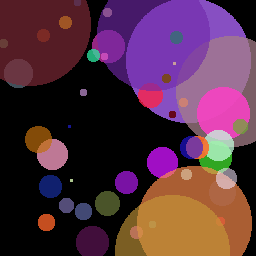

174	29    	6.73406e-05	0.998494  	0.998319  	0.998041   
175	29    	7.07864e-05	0.998494  	0.998343  	0.99803    
176	28    	0.00261783 	0.998557  	0.997968  	0.979821   
177	29    	0.0544249  	0.998636  	0.990569  	0.609621   
178	22    	0.0106469  	0.998733  	0.996933  	0.922429   
179	32    	9.55853e-05	0.998733  	0.998537  	0.998318   
180	32    	0.0003516  	0.998749  	0.998525  	0.996578   
181	25    	0.000418562	0.998811  	0.998632  	0.995746   
182	28    	0.00059698 	0.998841  	0.998595  	0.995773   
183	27    	4.78695e-05	0.998841  	0.998784  	0.998647   
184	27    	0.000181541	0.998851  	0.998779  	0.997542   
185	28    	0.000126667	0.998881  	0.99881   	0.997951   
186	37    	0.00178275 	0.998881  	0.998532  	0.986495   
187	27    	0.000226263	0.998885  	0.998819  	0.997237   
188	30    	1.55536e-05	0.998901  	0.998862  	0.998836   
189	27    	9.71928e-05	0.998907  	0.998859  	0.998334   
190	24    	6.19503e-05	0.99897   	0.998883  	0.998466   
191	18    	1.80226e-05	0.998973

In [11]:
try:
    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.1, ngen=NGEN, 
                               stats=stats, halloffame=hof, verbose=True)
except KeyboardInterrupt:
    display(circles_to_image(hof[0]))

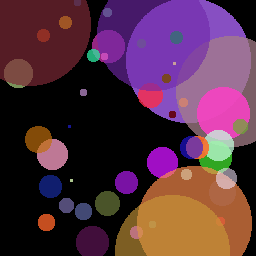

In [12]:
display(circles_to_image(hof[0]))
circles_to_image(hof[0]).save('output/nsfw-circle50.png')